In [16]:
###############
### Imports ###
###############
import os
import csv
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import * 
import matplotlib.pyplot as plt
import tensorflow.keras.models as models 
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense

In [17]:
###########################
### Basic configuration ###
###########################

# Ignore warnings about deprecated features
warnings.simplefilter(action = "ignore")

# Check the number of available GPUs
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Number of GPUs Available:", len(physical_devices))

# Set if memory growth should be enabled for a PhysicalDevice
if physical_devices: tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs Available: 1


In [18]:
############################################
#### Generation of the score dictionary  ### 
############################################

# Initialize the score dictionary
scores = {}
# Opening the score csv file
with open("scores.csv", mode = "r", encoding = "utf-8-sig") as file:
  # Reading the csv file
  scoreFile = csv.reader(file, delimiter = ";")
  # Save the contents of the CSV file
  for lines in scoreFile: 
    id = lines[0]
    score = lines[1]
    scores[id] = score

In [19]:
######################################################
### Generation of the locomotion matrix dictionary ###
######################################################

# Get the list of locomotion data files 
listLocomotionData = os.listdir("Locomotion")

# Initialize the data dictionary
data = {}
# Get the list of sensor names
sensor_names = pd.read_excel("Locomotion/" + listLocomotionData[0]).columns

# Iterate through the score dictionary
for key, value in scores.items(): 
  # Iterate through the list of locomotion data files 
  for locomotion in listLocomotionData: 
    if key in locomotion:
      df = pd.read_excel ("Locomotion/" + locomotion)
      df = df.dropna(how = "all")
      df = df.fillna(0)
      df = df.to_numpy()
      data[key] = df

In [20]:
######################################
### Set dimensions of the matrices ###
######################################

# Initialize the number of rows and columns
n_rows = []
n_columns = 60

# Iterate through the data dictionary
for key, value in data.items(): 
  # Save the number of rows of the actual array
  n_rows.append(value.shape[0])
# Set the number of rows for all arrays with he minimal value
n_rows = max(n_rows)
# Print the number of rows and columns
print("COLUMNS:", n_columns, "ROWS:", n_rows)

COLUMNS: 60 ROWS: 502


In [21]:
#############################################################
### Generation of matrices and imputation of missing data ###
#############################################################

# Initialize the feature matrix and the class vector
X = []
y = []

# Iterate through the data dictionary
for key, value in data.items():
  
  # Build the features matrix
  if scores[key] == "2" or scores[key] == "2,5" or scores[key] == "3" or scores[key] == "3,5":
    matrix = []
    for i in range(n_columns):
      sequence = []
      for j in range(n_rows):
        try: sequence.append(float(value[j][i]))
        except:sequence.append(float(0))
      sequence = np.array(sequence)
      matrix.append(sequence)
    matrix = np.array(matrix)
    X.append(matrix)

    # Save the classes
    if scores[key] == "2": y.append(0)
    elif scores[key] == "2,5":y.append(1)
    elif scores[key] == "3":y.append(2)
    elif scores[key] == "3,5" :y.append(3)
    else: pass

# Transform the matrix avec vector to numpy array
X = np.array(X)
y = np.array(y)

In [22]:
#############################
### Get data informations ###
#############################
n_instances = X.shape[0]
n_features = X.shape[1]
n_values = X.shape[2]
print("Number of instances =", n_instances, 
      "\nNumber of features per instance =", n_features, 
      "\nNumber of values per feature =", n_values)

Number of instances = 74 
Number of features per instance = 60 
Number of values per feature = 502


In [23]:
#####################################
### Display the data informations ###
#####################################
print("Matrice =", X.shape)
print("Classes =", set(y))
print("Example of instance =\n", X[0])
print("First value of the first feature of the first instance =", X[0][0][0])
print("Middle value of the middle feature of the middle instance =", X[int(n_instances / 2)][int(n_features /2)][int(n_values /2)])
print("Last value of the last feature of the last instance =", X[n_instances - 1][n_features - 1][n_values - 1])

Matrice = (74, 60, 502)
Classes = {0, 1, 2, 3}
Example of instance =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First value of the first feature of the first instance = 0.0
Middle value of the middle feature of the middle instance = 29.043
Last value of the last feature of the last instance = 0.0


In [24]:
#################################
### Perform data augmentation ###
#################################

# Initialize the feature matrix and the class vector for generated data
X_Generated = []
y_Generated = []

# Set the variables
variation_percentage = 5

# Iterate through the instances of X
for i, x in enumerate(X):
    
    # Set the number of instance to generate balanced dataset
    if y[i] == 0: n_generated_instances = 125
    if y[i] == 1: n_generated_instances = 84
    if y[i] == 2: n_generated_instances = 132
    if y[i] == 3: n_generated_instances = 500
    
    # Iterate through the inumber of instances to generate
    for j in range(int(n_generated_instances)):
        # Initialize the vector to save the new matrix
        x_Generated = []
        # Iterate through the row of the actual instance
        for row in x:
            # Initialize the vector to save the new row
            x_Generated_Row = []
            # Iterate through the value of the actual row
            for value in row:
                # Generate random variation for the instance
                random_number = random.random()  * variation_percentage / 100
                # Generate boolen to add or remove the variation
                boolean = random.randint(0 , 1)
                # Save value adding variation
                if boolean == 0: x_Generated_Row.append(value + value * random_number)
                # Save value removing variation
                else: x_Generated_Row.append(value - value * random_number)
            # Convert the row vector to numpy array
            x_Generated_Row = np.array(x_Generated_Row)
            # Save the row vector
            x_Generated.append(x_Generated_Row)
        # Convert the matrix vector to numpy matrix
        x_Generated = np.array(x_Generated)
        # Save the generated matrix
        X_Generated.append(x_Generated)
        # Save the associated classes
        y_Generated.append(y[i])

# Transform the matrix avec vector to numpy array
X_Generated = np.array(X_Generated)
y_Generated = np.array(y_Generated)

In [25]:
#####################################
### Display the data informations ###
#####################################
print("Matrice:", X_Generated.shape)
print("Classes:", set(y_Generated))
print("Number of targets: ", y_Generated.shape)
print("Example of instance:", X_Generated[0])
print("Example of shape of instance:", X_Generated[0].shape)

Matrice: (10028, 60, 502)
Classes: {0, 1, 2, 3}
Number of targets:  (10028,)
Example of instance: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Example of shape of instance: (60, 502)


In [26]:
#################################
### Generate Train/Test Split ###
#################################
X_train, X_test, y_train, y_test = train_test_split(X_Generated, y_Generated, test_size = 0.20, random_state = 42)
X_train = X_train.reshape((len(X_train), n_columns, n_rows, 1))
X_test = X_test.reshape((len(X_test), n_columns, n_rows, 1))
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)

X_train shape = (8022, 60, 502, 1)
X_test shape = (2006, 60, 502, 1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 58, 500, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 250, 16)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 29, 250, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 248, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 124, 32)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 124, 32)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 122, 16)      

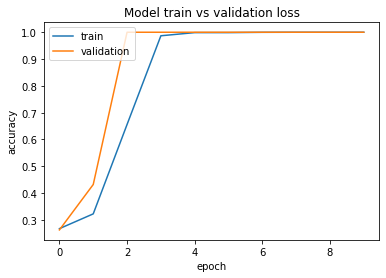

In [27]:
#################
### CNN Model ###
#################

# Build the CNN 
model = models.Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(n_columns, n_rows, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(n_columns, n_rows, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(n_columns, n_rows, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation ="relu"))
model.add(Dense(4, activation="softmax"))
model.summary()

# Compile the model 
model .compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics =["accuracy"])

# Fit the model
history = model.fit(x = X_train, y = y_train, validation_split = 0.10, epochs = 10, shuffle = True, verbose = 1)

# Plot the history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model train vs validation loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

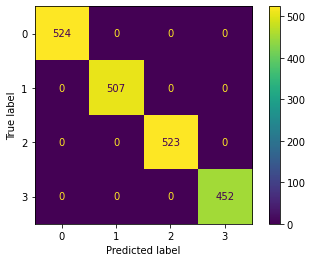


Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       524
           1      1.000     1.000     1.000       507
           2      1.000     1.000     1.000       523
           3      1.000     1.000     1.000       452

    accuracy                          1.000      2006
   macro avg      1.000     1.000     1.000      2006
weighted avg      1.000     1.000     1.000      2006



In [28]:
#######################
### LSTM Model Test ###
#######################

# Predict test data
y_pred = model.predict(x = X_test)

# Convert to rounded prediction
y_pred = np.argmax(y_pred, axis = -1)

# Compute confusion matrix
cm = confusion_matrix(y_true = y_test , y_pred=y_pred)

# Set the labels
target_names = ['0','1','2','3']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
disp = disp.plot()
plt.show()

# Display the classification report
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names = target_names, digits = 3))